# Graph Data Analysis

## Notebook 1

This notebook will introduce using graph algorithms for exploratory data analysis.

## Connect to TigerGraph Database

The code block below connects to a TigerGraph database. Make sure to change the authentication details in order for you to connect to the instance successfully.

In [1]:
import pyTigerGraph as tg

hostName = "YOUR_HOST_HERE"
gsqlSecret = "YOUR_SECRET_HERE"
graphname= "KDD_2022_NFT"

conn = tg.TigerGraphConnection(host=hostName, graphname="KDD_2022_NFT", gsqlSecret=gsqlSecret)
conn.getToken(gsqlSecret)

## PyTigerGraph Graph Data Science Featurizer

The code block below instantiates a `featurizer`, which allows developers to easily run graph algorithms on their database, directly from Python.

In [2]:
featurizer = conn.gds.featurizer()

## Centrality Algorithms

**From Wikipedia:** _In graph theory and network analysis, indicators of centrality assign numbers or rankings to nodes within a graph corresponding to their network position. Applications include identifying the most influential person(s) in a social network, key infrastructure nodes in the Internet or urban networks, super-spreaders of disease, and brain networks. Centrality concepts were first developed in social network analysis, and many of the terms used to measure centrality reflect their sociological origin._

In the context of this demo, we will be using a centrality measure to determine the more influential users in the NFT marketplace.

In [3]:
featurizer.listAlgorithms("Centrality")

Available algorithms for category Centrality in the GDS (https://github.com/tigergraph/gsql-graph-algorithms):
pagerank: 
 global: 
  weighted: 
   Algorithm Name: tg_pagerank_wt
   Algorithm Link: https://github.com/tigergraph/gsql-graph-algorithms/blob/master/algorithms/Centrality/pagerank/global/weighted/tg_pagerank_wt.gsql. 
  unweighted: 
   Algorithm Name: tg_pagerank
   Algorithm Link: https://github.com/tigergraph/gsql-graph-algorithms/blob/master/algorithms/Centrality/pagerank/global/unweighted/tg_pagerank.gsql. 
article_rank: 
 Algorithm Name: tg_article_rank
 Algorithm Link: https://github.com/tigergraph/gsql-graph-algorithms/blob/master/algorithms/Centrality/article_rank/tg_article_rank.gsql. 
Betweenness: 
 Algorithm Name: tg_betweenness_cent
 Algorithm Link: https://github.com/tigergraph/gsql-graph-algorithms/blob/master/algorithms/Centrality/betweenness/tg_betweenness_cent.gsql. 
closeness: 
 approximate: 
  Algorithm Name: tg_closeness_cent_approx
  Algorithm Link: http

## Installing and Running PageRank

To measure the centrality of certain users in the NFT transaction network, we choose to use PageRank. This is due to the recursive nature of defining PageRanks to vertices; we want more influential users to define who is the influence of other users.

In [4]:
featurizer.installAlgorithm("tg_pagerank")

'tg_pagerank'

In [5]:
params={"v_type": "NFT_User", "e_type": "USER_SOLD_TO", 'result_attr': 'pagerank'}

In [6]:
try:
    featurizer.runAlgorithm("tg_pagerank", params=params, feat_name="pagerank", schema_name=["NFT_User"], global_schema=False)
except ConnectionError:
    conn.runInstalledQuery("tg_pagerank", params=params)

## Creating Our Own Feature
**HANDS ON CODE:** Check `query_answers` directory if you are not participating in the live tutorial.

Here, we define our own feature using a GSQL query, and use the **featurizer** to install it. 

In [7]:
%%writefile ./average_selling_price.gsql



Overwriting ./average_selling_price.gsql


In [8]:
featurizer.installAlgorithm("average_selling_price", query_path="./average_selling_price.gsql")

'average_selling_price'

In [9]:
params = {
    "result_attr": "avg_sell_price"
}

In [10]:
try:
    featurizer.runAlgorithm("average_selling_price", params=params, feat_name="avg_sell_price", feat_type="FLOAT", custom_query=True, schema_name=["NFT_User"])
except ConnectionError:
    featurizer.runAlgorithm("average_selling_price", params=params)

## PageRank vs. Average Selling Price

Lets compare a user's PageRank score to the average selling price of that user.

In [11]:
df = conn.getVertexDataFrame("NFT_User", where="avg_sell_price > 0", limit=100_000)
pr_sell = df[["pagerank", "avg_sell_price"]]

<AxesSubplot:xlabel='pagerank', ylabel='avg_sell_price'>

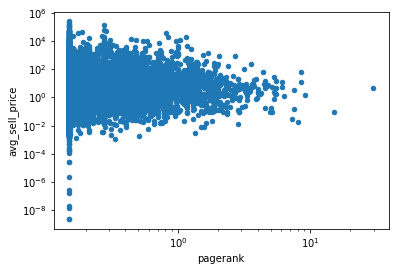

In [12]:
pr_sell.plot.scatter(x="pagerank", y="avg_sell_price", logx=True, logy=True)

### Remove Outliers

<AxesSubplot:xlabel='pagerank', ylabel='avg_sell_price'>

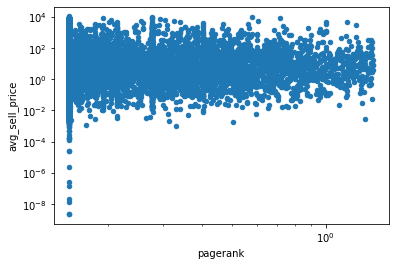

In [13]:
import numpy as np
from scipy import stats
pr_sell[(np.abs(stats.zscore(pr_sell)) < 3).all(axis=1)].plot.scatter(x="pagerank", y="avg_sell_price", logx=True, logy=True)

## Community Detection Algorithms

**From Wikipedia:** _In the study of complex networks, a network is said to have community structure if the nodes of the network can be easily grouped into (potentially overlapping) sets of nodes such that each set of nodes is densely connected internally. In the particular case of non-overlapping community finding, this implies that the network divides naturally into groups of nodes with dense connections internally and sparser connections between groups. But overlapping communities are also allowed. The more general definition is based on the principle that pairs of nodes are more likely to be connected if they are both members of the same community(ies), and less likely to be connected if they do not share communities. A related but different problem is community search, where the goal is to find a community that a certain vertex belongs to._

We want to include community features with our machine learning algorithms. If two users are in a small community, they might be more likely to sell at a lower price than a larger community.

In [14]:
featurizer.listAlgorithms("Community")

Available algorithms for category Community in the GDS (https://github.com/tigergraph/gsql-graph-algorithms):
connected_components: 
 strongly_connected_components: 
  standard: 
   Algorithm Name: tg_scc
   Algorithm Link: https://github.com/tigergraph/gsql-graph-algorithms/blob/master/algorithms/Community/connected_components/strongly_connected_components/standard/tg_scc.gsql. 
k_core: 
 Algorithm Name: tg_kcore
 Algorithm Link: https://github.com/tigergraph/gsql-graph-algorithms/blob/master/algorithms/Community/k_core/tg_kcore.gsql. 
label_propagation: 
 Algorithm Name: tg_label_prop
 Algorithm Link: https://github.com/tigergraph/gsql-graph-algorithms/blob/master/algorithms/Community/label_propagation/tg_label_prop.gsql. 
local_clustering_coefficient: 
 Algorithm Name: tg_lcc
 Algorithm Link: https://github.com/tigergraph/gsql-graph-algorithms/blob/master/algorithms/Community/local_clustering_coefficient/tg_lcc.gsql. 
louvain: 
 Algorithm Name: tg_louvain
 Algorithm Link: https://gi

## Installing and Running K-Core

A k-core of a graph is a maximal connected subgraph in which every vertex is connected to at least k vertices in the subgraph. To obtain the k-core of a graph, the algorithm first deletes the vertices whose outdegree is less than k. It then updates the outdegree of the neighbors of the deleted vertices, and if that causes a vertex’s outdegree to fall below k, it will also delete that vertex. The algorithm repeats this operation until every vertex left in the subgraph has an outdegree of at least k.

Our algorithm takes a range of values for k and returns the set of the vertices that constitute the k-core with the highest possible value of k within the range. It is an implementation of Algorithm 2 in [Scalable K-Core Decomposition for Static Graphs Using a Dynamic Graph Data Structure, Tripathy et al., IEEE Big Data 2018.](https://ieeexplore.ieee.org/document/8622056)


In [15]:
featurizer.installAlgorithm("tg_kcore")

'tg_kcore'

In [16]:
params = {
    "v_type": "NFT_User",
    "e_type": "USER_SOLD_TO",
    "print_accum": False,
    "result_attr": "k_core"
}
try:
    featurizer.runAlgorithm("tg_kcore", params = params, feat_name="k_core", schema_name=["NFT_User"])
except ConnectionError:
    featurizer.runAlgorithm("tg_kcore", params = params)

## K-Core Size vs. Average Selling Price

We are now going to compare the size of a user's k-core to their average selling price.

In [17]:
df = conn.getVertexDataFrame("NFT_User", where="avg_sell_price > 0", limit=100_000)
df.head()

,v_id,nft_user_id,username,embedding,pagerank,avg_sell_price,k_core,kcore_size,fastrp_embedding
0,5.sby.wam,5.sby.wam,,[],0.15,0.11192,1,0.75295,[]
1,qjtb2.wam,qjtb2.wam,,[],0.15,24.66600,1,0.75295,[]
2,0xb009388b7db8feb0891ba1e5c897f64110d10390,0xb009388b7db8feb0891ba1e5c897f64110d10390,,[],0.15,2259.84229,1,0.75295,[]
3,n2.b.wam,n2.b.wam,,[],0.15,41.73400,1,0.75295,[]
4,hpeby.wam,hpeby.wam,,[],0.15,0.05082,1,0.75295,[]


In [18]:
df["k_core"].value_counts()

1       15792
2        3351
3        1284
4         617
5         329
        ...  
80          1
1117        1
67          1
175         1
162         1
Name: k_core, Length: 75, dtype: int64

In [19]:
len(df["k_core"].unique())

75

In [20]:
kcore_pr_sell = df[["pagerank", "avg_sell_price", "k_core"]]

kcore_pr_sell.groupby(["k_core"]).mean()

,pagerank,avg_sell_price
k_core,,
1,0.185720,313.042701
2,0.325241,153.347616
3,0.306290,70.342354
4,0.324568,149.226587
5,0.372241,99.356170
...,...,...
175,0.150000,0.782850
240,0.356240,2.261080
313,0.150000,10.029490


In [21]:
size_of_core = df["k_core"].value_counts()

In [22]:
kcore_pr_sell["size_of_core"] = kcore_pr_sell["k_core"].apply(lambda x: size_of_core[x])

/tmp/ipykernel_3571/485414690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kcore_pr_sell["size_of_core"] = kcore_pr_sell["k_core"].apply(lambda x: size_of_core[x])


In [23]:
kcore_pr_sell.head()

,pagerank,avg_sell_price,k_core,size_of_core
0,0.15,0.11192,1,15792
1,0.15,24.66600,1,15792
2,0.15,2259.84229,1,15792
3,0.15,41.73400,1,15792
4,0.15,0.05082,1,15792


In [24]:
kcore_pr_sell[["avg_sell_price", "size_of_core"]].corr()

,avg_sell_price,size_of_core
avg_sell_price,1.000000,0.025765
size_of_core,0.025765,1.000000


<AxesSubplot:xlabel='size_of_core', ylabel='avg_sell_price'>

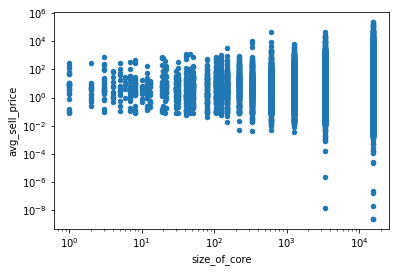

In [25]:
kcore_pr_sell.plot.scatter(x="size_of_core", y="avg_sell_price", logx=True, logy=True)

<AxesSubplot:xlabel='size_of_core', ylabel='avg_sell_price'>

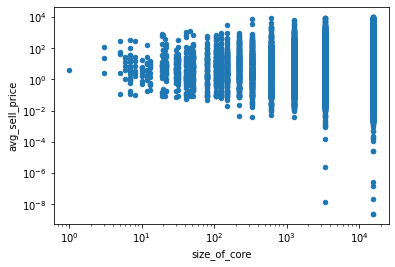

In [26]:
kcore_pr_sell[(np.abs(stats.zscore(kcore_pr_sell)) < 3).all(axis=1)].plot.scatter(x="size_of_core", y="avg_sell_price", logx=True, logy=True)

## Size of K-Core vs. PageRank
We want features to be non-correlated, so lets see if there is a correlation between the size of a community and the user's PageRank.

<AxesSubplot:xlabel='size_of_core', ylabel='pagerank'>

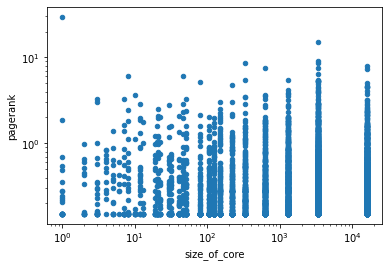

In [27]:
kcore_pr_sell.plot.scatter(x="size_of_core", y="pagerank", logx=True, logy=True)

<AxesSubplot:xlabel='size_of_core', ylabel='pagerank'>

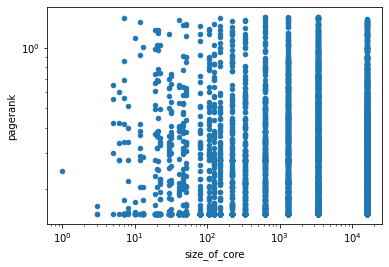

In [28]:
kcore_pr_sell[(np.abs(stats.zscore(kcore_pr_sell)) < 3).all(axis=1)].plot.scatter(x="size_of_core", y="pagerank", logx=True, logy=True)